In [3]:
# !pip install dash-cytoscape

In [152]:
# !pip install networkx

In [166]:
format_graph(wflows_meta)

[{'data': {'id': 'Data science team', 'label': 'Data science team'}},
 {'data': {'id': 'wflow1', 'label': 'wflow1', 'parent': 'Data science team'}},
 {'data': {'id': 'wflow1_0', 'label': 'wflow1_0', 'parent': 'wflow1'}},
 {'data': {'source': 'wflow1_0', 'target': 'wflow1_1'}},
 {'data': {'id': 'wflow1_1', 'label': 'wflow1_1', 'parent': 'wflow1'}},
 {'data': {'id': 'Data science team', 'label': 'Data science team'}},
 {'data': {'id': 'wflow2', 'label': 'wflow2', 'parent': 'Data science team'}},
 {'data': {'id': 'wflow2_0', 'label': 'wflow2_0', 'parent': 'wflow2'}},
 {'data': {'source': 'wflow2_0', 'target': 'wflow2_1'}},
 {'data': {'id': 'wflow2_1', 'label': 'wflow2_1', 'parent': 'wflow2'}},
 {'data': {'source': 'wflow2_1', 'target': 'wflow2_2'}},
 {'data': {'id': 'wflow2_2', 'label': 'wflow2_2', 'parent': 'wflow2'}},
 {'data': {'source': 'wflow2_2', 'target': 'wflow2_3'}},
 {'data': {'id': 'wflow2_3', 'label': 'wflow2_3', 'parent': 'wflow2'}},
 {'data': {'id': 'Data science team', 'lab

In [5]:
workflows = {'wflow1':3, 'wflow2':4, 'wflow3':3, 'wflow4':1}

wflows_meta = list()
for k, v in workflows.items():
    nodes = list()
    for node_i in range(v):
        nodes.append({'name': f'{k}_{node_i}', 'type': 'executor'})
    wflows_meta.append({'name': k, 'nodes': nodes})
    
wflows_meta

[{'name': 'wflow1',
  'nodes': [{'name': 'wflow1_0', 'type': 'executor'},
   {'name': 'wflow1_1', 'type': 'executor'},
   {'name': 'wflow1_2', 'type': 'executor'}]},
 {'name': 'wflow2',
  'nodes': [{'name': 'wflow2_0', 'type': 'executor'},
   {'name': 'wflow2_1', 'type': 'executor'},
   {'name': 'wflow2_2', 'type': 'executor'},
   {'name': 'wflow2_3', 'type': 'executor'}]},
 {'name': 'wflow3',
  'nodes': [{'name': 'wflow3_0', 'type': 'executor'},
   {'name': 'wflow3_1', 'type': 'executor'},
   {'name': 'wflow3_2', 'type': 'executor'}]},
 {'name': 'wflow4', 'nodes': [{'name': 'wflow4_0', 'type': 'executor'}]}]

In [1]:
wflows_meta = [{'name': 'workflow1',
  'nodes': [{'name': 'gathering',
    'image': '<Image: gathering:latest>',
    'type': 'executor',
    'status': 0,
    'port': None},
# {'name': 'gathering2',
#     'image': '<Image: gathering:latest>',
#     'type': 'executor',
#     'status': 0,
#     'port': None},
   {'name': 'preprocessing',
    'image': ['<Image: preprocessing:latest', 'localhost:5000/preprocessing:latest>'],
    'type': 'executor',
    'status': 0,
    'port': None},
   {'name': 'tracker-workflow1',
    'image': '<Image: tracker-workflow1:latest>',
    'type': 'tracker',
    'status': 0,
    'port': 8001}]},
 {'name': 'workflow2',
  'nodes': [{'name': 'modeling',
    'image': '<Image: modeling:latest>',
    'type': 'executor',
    'status': 0,
    'port': None},
# {'name': 'modeling',
#     'image': '<Image: modeling:latest>',
#     'type': 'executor',
#     'status': 0,
#     'port': None},
   {'name': 'tracker-workflow2',
    'image': '<Image: tracker-workflow2:latest>',
    'type': 'tracker',
    'status': 0,
    'port': 8002}]}]
wflows_meta

[{'name': 'workflow1',
  'nodes': [{'name': 'gathering',
    'image': '<Image: gathering:latest>',
    'type': 'executor',
    'status': 0,
    'port': None},
   {'name': 'preprocessing',
    'image': ['<Image: preprocessing:latest',
     'localhost:5000/preprocessing:latest>'],
    'type': 'executor',
    'status': 0,
    'port': None},
   {'name': 'tracker-workflow1',
    'image': '<Image: tracker-workflow1:latest>',
    'type': 'tracker',
    'status': 0,
    'port': 8001}]},
 {'name': 'workflow2',
  'nodes': [{'name': 'modeling',
    'image': '<Image: modeling:latest>',
    'type': 'executor',
    'status': 0,
    'port': None},
   {'name': 'tracker-workflow2',
    'image': '<Image: tracker-workflow2:latest>',
    'type': 'tracker',
    'status': 0,
    'port': 8002}]}]

In [51]:
t = [node['name'] for wflow in wflows_meta for node in wflow['nodes']]
t

['gathering',
 'preprocessing',
 'tracker-workflow1',
 'modeling',
 'tracker-workflow2']

In [65]:
def workflow_to_graph(wflows_meta, name='Graph 1'):
    all_nodes = list()
    last_nodes = list()
    if_tracker = 0
    for wflow in wflows_meta:
        # Parent nodes
        nodes = wflow['nodes']
        parent_node_name = wflow['name']
        # Root parent (e.g, Data science team)
        all_nodes.append({'data': {'id': name, 
                                   'label': name}})
        # Workflow parent (e.g, workflow1)
        all_nodes.append({'data': {'id': parent_node_name, 
                                   'label': parent_node_name,
                                   'parent': name}})

        if_tracker = int(any("tracker" in node['name'] for node in nodes))
        for i, node in enumerate(nodes):        
            children_node_name = node['name']
            if node['type'] == 'executor':
                # Children nodes
                all_nodes.append({'data': {'id': children_node_name, 
                                           'label': children_node_name,
                                           'parent': parent_node_name}})
                # Edges in each workflow
                if i+1+if_tracker < len(nodes):
                    all_nodes.append({'data': {'source': children_node_name, 
                                               'target': nodes[i+1]['name']}})

                if i == len(nodes)-(1 + if_tracker):
                    last_nodes.append(children_node_name)

        if_tracker = 0

    # Edges between workflows
    for i, last_node in enumerate(last_nodes):
        if i+1 < len(last_nodes):
            all_nodes.append({'data': {'source': last_node, 
                                   'target': last_nodes[i+1]}})       
    
    return all_nodes

dict_wflows = workflow_to_graph(wflows_meta)
dict_wflows

[{'data': {'id': 'Graph 1', 'label': 'Graph 1'}},
 {'data': {'id': 'workflow1', 'label': 'workflow1', 'parent': 'Graph 1'}},
 {'data': {'id': 'gathering', 'label': 'gathering', 'parent': 'workflow1'}},
 {'data': {'source': 'gathering', 'target': 'preprocessing'}},
 {'data': {'id': 'preprocessing',
   'label': 'preprocessing',
   'parent': 'workflow1'}},
 {'data': {'id': 'Graph 1', 'label': 'Graph 1'}},
 {'data': {'id': 'workflow2', 'label': 'workflow2', 'parent': 'Graph 1'}},
 {'data': {'id': 'modeling', 'label': 'modeling', 'parent': 'workflow2'}},
 {'data': {'source': 'preprocessing', 'target': 'modeling'}}]

In [54]:
# !pip install pygraphviz

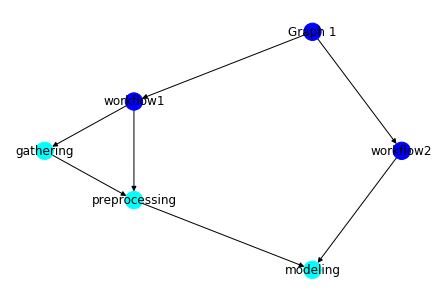

In [66]:
import matplotlib.pyplot as plt
import networkx as nx
# from networkx.drawing.nx_agraph import write_dot, graphviz_layout

def draw_graph(dict_wflows):
    G = nx.DiGraph(directed=True)

    edges_with_parent = [(d['data']['parent'], d['data']['id']) 
              for d in dict_wflows if 'parent' in d['data'].keys()]
    parent_nodes = {edge[0]:'blue' for edge in edges_with_parent}
    # color_map = ['blue' for e in edges]
    edges_rest = [(d['data']['source'], d['data']['target']) 
              for d in dict_wflows if 'source' in d['data'].keys()]

    rest_nodes = {edge:'cyan' for edge in list(set(list(sum(edges_rest, ()))))}

    total_edges = edges_with_parent + edges_rest

    G.add_edges_from(total_edges) 

#     plt.title('Topology')
    pos = nx.spectral_layout(G)
    color_nodes = {**parent_nodes, **rest_nodes}
    color_map = [color_nodes[node] for node in G.nodes()]
    nx.draw(G, pos, node_color=color_map, with_labels = True, arrows=True)
    plt.show()

draw_graph(dict_wflows)
# pos =graphviz_layout(G, prog='dot')
# nx.draw(G, pos, with_labels=False, arrows=True)
# plt.savefig('nx_test.png')

In [58]:
color_nodes

{'Data science team': 'blue',
 'workflow1': 'blue',
 'workflow2': 'blue',
 'g': 'cyan',
 'm': 'cyan',
 'p': 'cyan'}

In [52]:
dict(edges_rest)

{'gathering': 'preprocessing', 'preprocessing': 'modeling'}

In [56]:
list(set(list(sum(edges_rest, ()))))

['gathering', 'modeling', 'preprocessing']

In [35]:
G.nodes()

NodeView(('Data science team', 'workflow1', 'gathering', 'preprocessing', 'workflow2', 'modeling'))

In [7]:
import jupyterlab_dash
import dash
import math
import dash_cytoscape as cyto
import dash_html_components as html

viewer = jupyterlab_dash.AppViewer()
app = dash.Dash(__name__)

app.layout = html.Div([
    cyto.Cytoscape(
        id='cytoscape-compound',
#         layout={'name': 'grid',
#                 'rows': 2},
#         layout={
#             'name': 'circle',
#             'radius': 250,
#             'startAngle': math.pi * 1/6,
#             'sweep': math.pi * 2/3
#         },
#         layout={
#             'name': 'breadthfirst',
#             'roots': '[id = "workflow1"]'
#         },
        layout={
            'name': 'breadthfirst'
        },
        style={'width': '100%', 'height': '600px'},
        stylesheet=[
            {
                'selector': 'node',
                'style': {'content': 'data(label)'}
            },
            {
                'selector': '.countries',
                'style': {'width': 5}
            },
            {
                'selector': '.cities',
                'style': {'line-style': 'dashed'}
            }
        ],
        elements=format_graph(wflows_meta),
    )
])

In [8]:
viewer.show(app)

In [3]:
# !pip install "jupyterlab>=1.0" jupyterlab-dash==0.1.0a3
# !jupyter labextension install jupyterlab-dash@0.1.0-alpha.3

In [ ]:
[
            # Parent Nodes
            {
                'data': {'id': 'us', 'label': 'United States'}
            },
            {
                'data': {'id': 'can', 'label': 'Canada'}
            },
            # Edges
            {
                'data': {'source': 'can', 'target': 'us'},
                'classes': 'countries'
            },
            # Children Nodes
            {
                'data': {'id': 'nyc', 'label': 'New York', 'parent': 'us'},
                'position': {'x': 100, 'y': 100}
            },
            {
                'data': {'id': 'sf', 'label': 'San Francisco', 'parent': 'us'},
                'position': {'x': 100, 'y': 200}
            },
            {
                'data': {'id': 'mtl', 'label': 'Montreal', 'parent': 'can'},
                'position': {'x': 400, 'y': 100}
            },

#             # Edges
#             {
#                 'data': {'source': 'can', 'target': 'us'},
#                 'classes': 'countries'
#             },
            {
                'data': {'source': 'nyc', 'target': 'sf'},
                'classes': 'cities'
            },
            {
                'data': {'source': 'sf', 'target': 'mtl'},
                'classes': 'cities'
            }
        ]